In [1]:
import os
import time
import numpy as np
import cv2
import torch
from torch import nn
import gym
from matplotlib import pyplot as plt

from nes_py.wrappers import JoypadSpace

import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym.wrappers import GrayScaleObservation

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [2]:
torch.version.cuda, torch.cuda.is_available()

('12.4', True)

In [3]:
base_path='C:\\Projects\\rl_mario\\'

In [4]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

C:\ProgramData\anaconda3\envs\rl_mario\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\ProgramData\anaconda3\envs\rl_mario\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\anaconda3\envs\rl_mario\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
# # run it
# done = True
# for step in range(5000):
#     if done:
#         state = env.reset()
#     state, reward, done, info = env.step(env.action_space.sample())
#     time.sleep(0.01)
#     env.render()

In [6]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

In [7]:
class ResizeEnv(gym.ObservationWrapper):
    def __init__(self, env, size):
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (size, size, oldc)
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=newshape, dtype=np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:,:,None]
        return frame

In [8]:
# training env
monitor_dir = base_path + r'./monitor_log/'
os.makedirs(monitor_dir,exist_ok=True)
env = Monitor(env,monitor_dir)

env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env, keep_dim=True)
env = ResizeEnv(env, size=84)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

In [9]:
env.reset()
state, reward, done, info = env.step([0])
state.shape

C:\ProgramData\anaconda3\envs\rl_mario\lib\site-packages\gym\utils\passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
C:\ProgramData\anaconda3\envs\rl_mario\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


(1, 84, 84, 4)

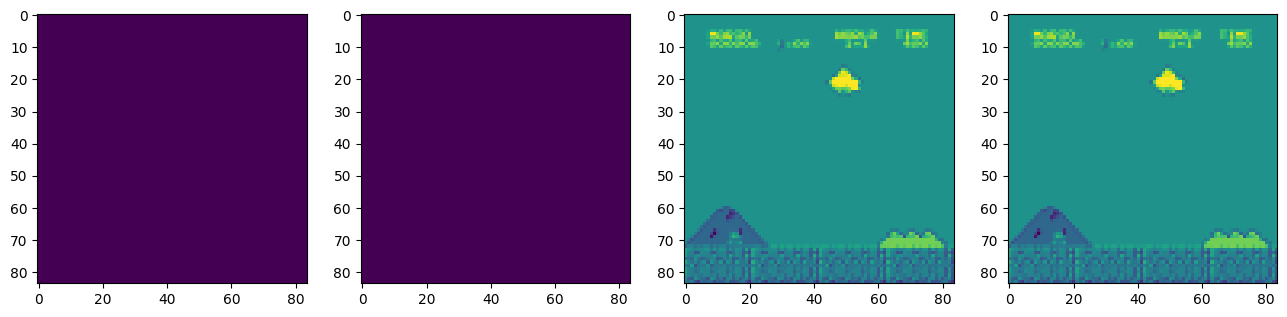

In [10]:
def display_all_frame():
    plt.figure(figsize=(16,16))
    for idx in range(state.shape[3]):
        plt.subplot(1,4,idx+1)
        plt.imshow(state[0][:,:,idx])
    plt.show()
    
display_all_frame()

In [11]:
best_params={
    'n_steps': 512,
    'learning_rate': 3e-7
}
best_params

{'n_steps': 512, 'learning_rate': 3e-07}

In [12]:
tensorboard_log = base_path + r'./logs/'

In [13]:
class MarioNet(BaseFeaturesExtractor):

    def __init__(self, observation_space: gym.spaces.Box, features_dim):
        super(MarioNet, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=MarioNet,
    features_extractor_kwargs=dict(features_dim=512),
)

In [14]:
model = PPO(
    "CnnPolicy", 
    env, 
    verbose=1,
    policy_kwargs=policy_kwargs,
    #learning_rate=linear_schedule(3e-4),
    device='cuda',
    tensorboard_log = tensorboard_log,
    **best_params
)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [15]:
#model.set_parameters(r'C:\\Projects\\rl_mario\\models\\back\\model_20241201.zip')

In [16]:
class SaveCallback(BaseCallback):

    def __init__(self, check_freq, save_model_dir, verbose=1):
        super(SaveCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = os.path.join(save_model_dir, 'models/')
        self.best_mean_reward = -np.inf

    # def _init_callback(self) -> None:
    def _init_callback(self):
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    # def _on_step(self) -> bool:
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            print('self.n_calls: ',self.n_calls)
            model_path1 = os.path.join(self.save_path, 'model_{}'.format(self.n_calls))
            self.model.save(model_path1)

        return True

In [17]:
# Linear learning rate schedule
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#learning-rate-schedule
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [17]:
callback = SaveCallback(1000, base_path)
model.learn(total_timesteps=1000,callback=callback)

Logging to C:\Projects\rl_mario\./logs/PPO_10
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 705      |
|    ep_rew_mean     | 404      |
| time/              |          |
|    fps             | 84       |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 512      |
---------------------------------
self.n_calls:  1000
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 900           |
|    ep_rew_mean          | 494           |
| time/                   |               |
|    fps                  | 80            |
|    iterations           | 2             |
|    time_elapsed         | 12            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.0593794e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss     